In [1]:
import os
from pyspark.sql import SparkSession

os.environ["HADOOP_HOME"] = "C:/hadoop"
os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk-20"

spark = SparkSession.builder \
    .appName("TwitterSentimentAnalysis") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Spark session initialized successfully!")


Spark session initialized successfully!


In [2]:
df = spark.read.csv("D:/twitter project/crowdflower-airline-twitter-sentiment/data/airline_sentiment_2_w_aa.csv", header=True, inferSchema=True)
df.show(5)


+---------+------+----------+-----------------+-------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------+--------------------+-----------+-------------------+------------------+--------------+--------------------+
|  unit_id|golden|unit_state|trusted_judgments|   last_judgment_at|airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|       airline|airline_sentiment_gold|      name|negativereason_gold|retweet_count|                text|tweet_coord|      tweet_created|          tweet_id|tweet_location|       user_timezone|
+---------+------+----------+-----------------+-------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------+--------------------+-----------+-------------------+---------------

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.sql.types import StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover

spark = SparkSession.builder.appName("TwitterSentimentAnalysis").getOrCreate()

df = spark.read.csv("D:/twitter project/crowdflower-airline-twitter-sentiment/data/airline_sentiment_2_w_aa.csv", header=True, inferSchema=True)

df = df.na.drop(subset=["text"])

df = df.withColumn("text", df["text"].cast(StringType()))

df = df.withColumn("text", lower(col("text")))

df = df.withColumn("text", regexp_replace(col("text"), "[^a-zA-Z\\s]", ""))

tokenizer = Tokenizer(inputCol="text", outputCol="words")
df = tokenizer.transform(df)

remover = StopWordsRemover(inputCol="words", outputCol="filtered_text")
df = remover.transform(df)

df.select("text", "filtered_text").show(truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                  |filtered_text                                                                                                                   |
+--------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------+
|virginamerica what dhepburn said                                                                                                      |[virginamerica, dhepburn, said]                                   

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.sql.types import StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover

spark = SparkSession.builder.appName("TwitterSentimentAnalysis").getOrCreate()

df = spark.read.csv("D:/twitter project/crowdflower-airline-twitter-sentiment/data/airline_sentiment_2_w_aa.csv", header=True, inferSchema=True)

df = df.na.drop(subset=["text"])

df = df.withColumn("text", df["text"].cast(StringType()))

df = df.withColumn("text", lower(col("text")))

df = df.withColumn("text", regexp_replace(col("text"), "[^a-zA-Z\\s]", ""))

tokenizer = Tokenizer(inputCol="text", outputCol="words")
df = tokenizer.transform(df)

remover = StopWordsRemover(inputCol="words", outputCol="filtered_text")
df = remover.transform(df)

df.select("text", "filtered_text").show(truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                  |filtered_text                                                                                                                   |
+--------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------+
|virginamerica what dhepburn said                                                                                                      |[virginamerica, dhepburn, said]                                   

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, HashingTF, IDF

spark = SparkSession.builder.appName("TwitterSentimentAnalysis").getOrCreate()

df = spark.read.csv("D:/twitter project/crowdflower-airline-twitter-sentiment/data/airline_sentiment_2_w_aa.csv", header=True, inferSchema=True)

df = df.na.drop(subset=["text"])

df = df.withColumn("text", lower(col("text")))

df = df.withColumn("text", regexp_replace(col("text"), "[^a-zA-Z\\s]", ""))

tokenizer = Tokenizer(inputCol="text", outputCol="words")
df = tokenizer.transform(df)

hashingTF = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=10000)
featurized_data = hashingTF.transform(df)

idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data)

rescaled_data.select("words", "raw_features", "features").show(truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StringIndexer

spark = SparkSession.builder.appName("TwitterSentimentAnalysis").getOrCreate()

df = spark.read.csv("D:/twitter project/crowdflower-airline-twitter-sentiment/data/airline_sentiment_2_w_aa.csv", header=True, inferSchema=True)

df = df.na.drop(subset=["text", "airline_sentiment"])

df = df.withColumn("text", lower(col("text")))

df = df.withColumn("text", regexp_replace(col("text"), "[^a-zA-Z\\s]", ""))

tokenizer = Tokenizer(inputCol="text", outputCol="words")
df = tokenizer.transform(df)

hashingTF = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=10000)
featurized_data = hashingTF.transform(df)

idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data)

indexer = StringIndexer(inputCol="airline_sentiment", outputCol="label")
indexed_data = indexer.fit(rescaled_data).transform(rescaled_data)

indexed_data.select("airline_sentiment", "label", "features").show(truncate=False)


+-----------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|airline_sentiment|label|features                                                                                                                                                                                                                                                                                                                  

In [7]:
train_data, test_data = indexed_data.randomSplit([0.8, 0.2], seed=42)

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label")

lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

predictions.select("airline_sentiment", "label", "prediction", "features").show(truncate=False)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")


+-----------------+-----+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|airline_sentiment|label|prediction|features                                                                                                                                                                                                                                                                                                                                                               

In [8]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

nb = NaiveBayes(featuresCol='features', labelCol='label')
nb_model = nb.fit(train_data)

predictions = nb_model.transform(test_data)

predictions.select("airline_sentiment", "label", "prediction", "features").show(truncate=False)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")


+-----------------+-----+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|airline_sentiment|label|prediction|features                                                                                                                                                                                                                                                                                                                                                               

In [9]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = lr_model.transform(test_data)

predictions.select("airline_sentiment", "label", "prediction", "features").show(truncate=False)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy}")


+-----------------+-----+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|airline_sentiment|label|prediction|features                                                                                                                                                                                                                                                                                                                                                               

In [10]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=20)

rf_model = rf.fit(train_data)

predictions = rf_model.transform(test_data)

predictions.select("airline_sentiment", "label", "prediction", "features").show(truncate=False)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy}")


+-----------------+-----+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|airline_sentiment|label|prediction|features                                                                                                                                                                                                                                                                                                                                                               

In [11]:
pandas_df = lr_model.transform(test_data).select("features", "prediction").toPandas()


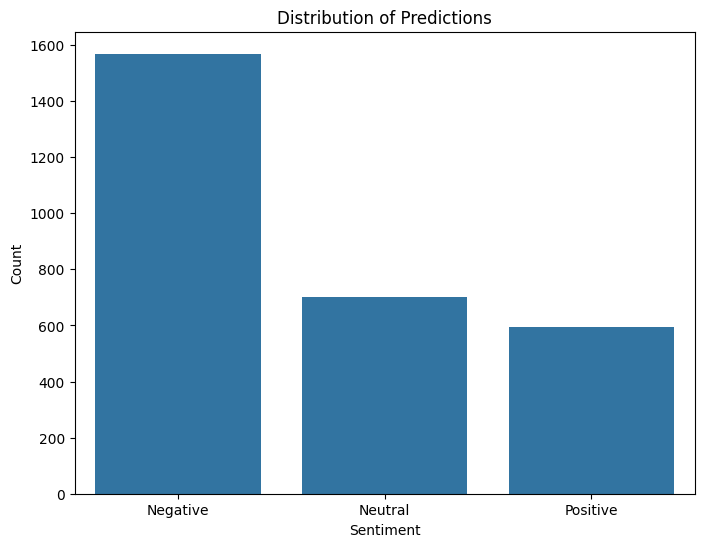

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

label_mapping = {0.0: "Negative", 1.0: "Neutral", 2.0: "Positive"}

pandas_df["prediction_label"] = pandas_df["prediction"].map(label_mapping)

plt.figure(figsize=(8, 6))
sns.countplot(x="prediction_label", data=pandas_df, order=["Negative", "Neutral", "Positive"])
plt.title("Distribution of Predictions")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


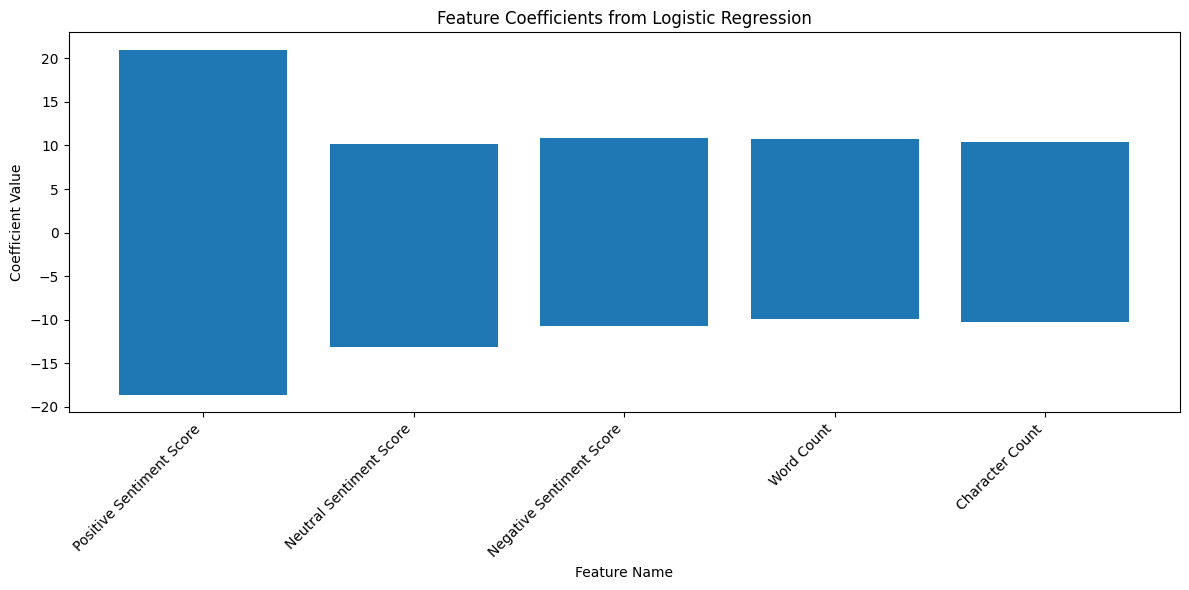

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

feature_names = [
    "Positive Sentiment Score",
    "Negative Sentiment Score",
    "Neutral Sentiment Score",
    "Word Count",
    "Character Count"
]

if lr_model.numClasses > 2:
    coefficients = lr_model.coefficientMatrix.toArray()
    coefficients_flat = coefficients.flatten()
    
    coefficients_df = pd.DataFrame({
        "Feature Name": [feature_names[i % len(feature_names)] for i in range(len(coefficients_flat))],
        "Coefficient": coefficients_flat
    })
else:
    coefficients = lr_model.coefficients.toArray()
    
    coefficients_df = pd.DataFrame({
        "Feature Name": feature_names[:len(coefficients)],
        "Coefficient": coefficients
    })

coefficients_df["Absolute Coefficient"] = coefficients_df["Coefficient"].abs()
coefficients_df = coefficients_df.sort_values(by="Absolute Coefficient", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(coefficients_df["Feature Name"], coefficients_df["Coefficient"])
plt.title("Feature Coefficients from Logistic Regression")
plt.xlabel("Feature Name")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [15]:
pandas_df = lr_model.transform(test_data).select("prediction").toPandas()

prediction_counts = pandas_df["prediction"].value_counts()

print(prediction_counts)


prediction
0.0    1569
1.0     700
2.0     593
Name: count, dtype: int64


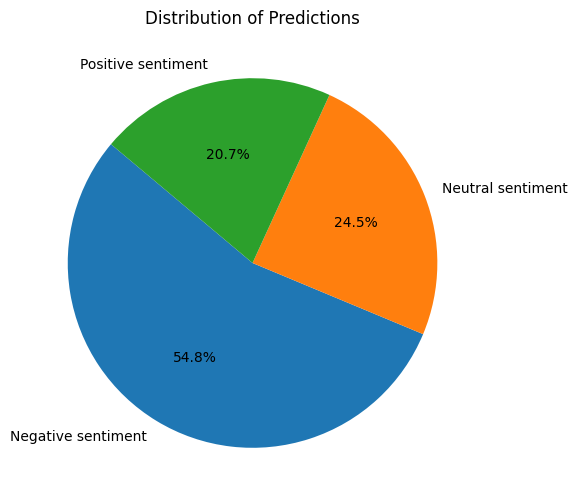

In [16]:
import matplotlib.pyplot as plt

label_mapping = {0.0: "Negative sentiment", 1.0: "Neutral sentiment", 2.0: "Positive sentiment"}

mapped_labels = [label_mapping[label] for label in prediction_counts.index]

plt.figure(figsize=(8, 6))
plt.pie(prediction_counts, labels=mapped_labels, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Predictions")
plt.show()


In [17]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='features', labelCol='label')

lr_model = lr.fit(train_data)


In [18]:
predictions = lr_model.transform(test_data)


In [19]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

accuracy = accuracy_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

import pandas as pd

metrics_dict = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Value": [accuracy, precision, recall, f1_score]
}

metrics_df = pd.DataFrame(metrics_dict)

metrics_df


,Metric,Value
0,Accuracy,0.660028
1,Precision,0.684012
2,Recall,0.660028
3,F1-Score,0.668731


In [20]:
df = df.toPandas()


In [22]:
df = df.apply(pd.to_numeric, errors='coerce')


In [23]:

df = df.replace({'true': 1, 'false': 0, True: 1, False: 0})


In [24]:

columns_to_drop = ['non_numeric_column1', 'non_numeric_column2']
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]


df = df.drop(columns=existing_columns_to_drop)


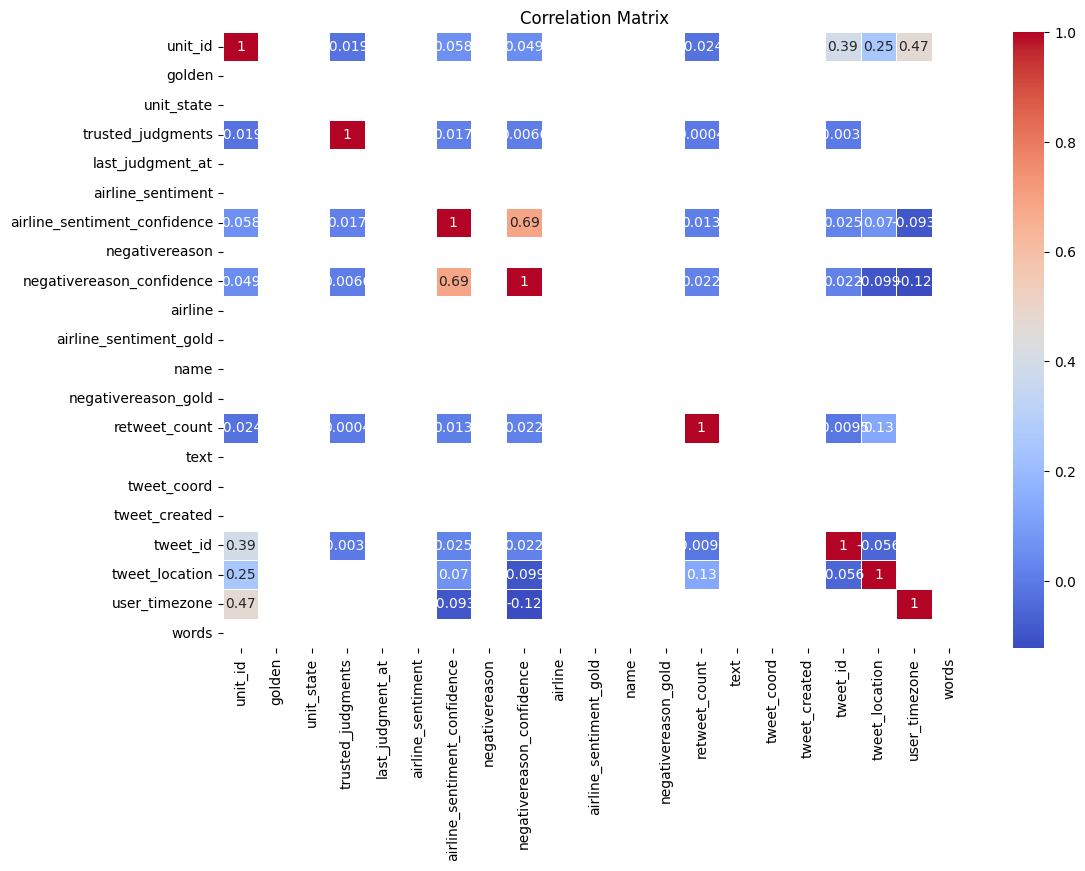

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt


numeric_df = df.select_dtypes(include=[float, int])


correlation_matrix = numeric_df.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


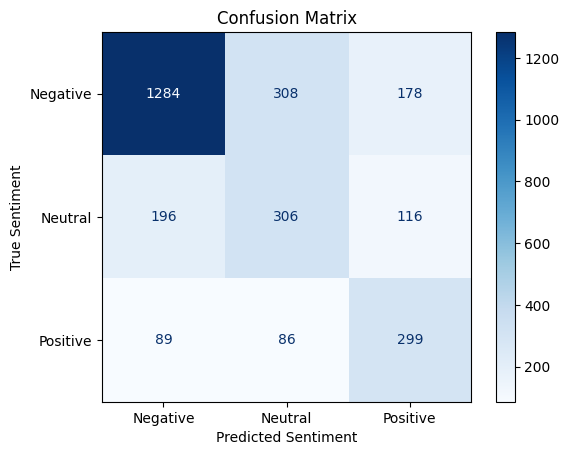

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


y_true = predictions.select("label").toPandas().values.flatten()
y_pred = predictions.select("prediction").toPandas().values.flatten()


cm = confusion_matrix(y_true, y_pred)


class_labels = ["Negative", "Neutral", "Positive"]


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Sentiment")
plt.ylabel("True Sentiment")
plt.show()


In [30]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier


models = {
    "Logistic Regression": lr_model,
    "Decision Tree": DecisionTreeClassifier(featuresCol="features", labelCol="label").fit(train_data),
    "Random Forest": RandomForestClassifier(featuresCol="features", labelCol="label").fit(train_data)
}


results = []
for model_name, model in models.items():
    predictions = model.transform(test_data)
    accuracy = accuracy_evaluator.evaluate(predictions)
    results.append({"Model": model_name, "Accuracy (%)": accuracy * 100})


accuracy_df = pd.DataFrame(results)
accuracy_df


,Model,Accuracy (%)
0,Logistic Regression,66.002795
1,Decision Tree,67.120894
2,Random Forest,61.844864


In [31]:

train_predictions = lr_model.transform(train_data)
train_accuracy = accuracy_evaluator.evaluate(train_predictions)


test_accuracy = accuracy_evaluator.evaluate(predictions)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Training Accuracy: 99.47%
Test Accuracy: 61.84%


In [1]:
from jupyter_dash import JupyterDash
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

data = {
    'Sentiment': ['Positive', 'Negative', 'Neutral'],
    'Count': [150, 200, 100]
}
df = pd.DataFrame(data)

app = JupyterDash(__name__)

app.layout = html.Div([
    html.H1("Sentiment Analysis Dashboard", style={'textAlign': 'center'}),
    dcc.Graph(
        id='pie-chart',
        figure=px.pie(df, names='Sentiment', values='Count', title='Sentiment Distribution')
    )
])

app.run_server(mode='inline')


c:\Users\neoro\AppData\Local\Programs\Python\Python310\lib\site-packages\dash\dash.py:585: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



In [6]:
from jupyter_dash import JupyterDash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

data = {
    'Sentiment': ['Positive', 'Negative', 'Neutral'],
    'Count': [150, 200, 100]
}
df = pd.DataFrame(data)

app = JupyterDash(__name__)
app.config.suppress_callback_exceptions = True

app.layout = html.Div([
    html.H1("Sentiment Analysis Dashboard", style={'textAlign': 'center'}),
    dcc.Dropdown(
        id='sentiment-dropdown',
        options=[{'label': s, 'value': s} for s in df['Sentiment']],
        value='Positive',
        clearable=False,
        style={'width': '50%', 'margin': 'auto'}
    ),
    dcc.Graph(id='bar-chart'),
    dcc.Graph(
        id='pie-chart',
        figure=px.pie(df, names='Sentiment', values='Count', title='Sentiment Distribution')
    )
])

@app.callback(
    Output('bar-chart', 'figure'),
    [Input('sentiment-dropdown', 'value')]
)
def update_bar_chart(selected_sentiment):
    filtered_df = df[df['Sentiment'] == selected_sentiment]
    fig = px.bar(filtered_df, x='Sentiment', y='Count', title=f'Count of {selected_sentiment} Tweets')
    return fig

app.run_server(mode='external', port=8051, debug=True)


c:\Users\neoro\AppData\Local\Programs\Python\Python310\lib\site-packages\dash\dash.py:585: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



Dash app running on http://127.0.0.1:8051/


In [7]:
import webbrowser

webbrowser.open("http://127.0.0.1:8051/")

app.run_server(port=8051, debug=True)


TypeError: 'NoneType' object cannot be interpreted as an integer

In [9]:
from jupyter_dash import JupyterDash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objs as go
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


np.random.seed(0)
data = {
    'Sentiment': ['Positive', 'Negative', 'Neutral'],
    'Count': [150, 200, 100],
    'Score': np.random.rand(3) * 100
}
df = pd.DataFrame(data)


X = df[['Score']].values
y = np.where(df['Sentiment'] == 'Positive', 1, 0)  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)


X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_prob = log_reg.predict_proba(X_range)[:, 1]


app = JupyterDash(__name__)
app.config.suppress_callback_exceptions = True


app.layout = html.Div([
    html.H1("Sentiment Analysis Dashboard", style={'textAlign': 'center'}),
    dcc.Dropdown(
        id='sentiment-dropdown',
        options=[{'label': s, 'value': s} for s in df['Sentiment']],
        value='Positive',
        clearable=False,
        style={'width': '50%', 'margin': 'auto'}
    ),
    dcc.Graph(id='bar-chart'),
    dcc.Graph(
        id='pie-chart',
        figure=px.pie(df, names='Sentiment', values='Count', title='Sentiment Distribution')
    ),
    dcc.Graph(id='logistic-regression-graph')
])


@app.callback(
    Output('bar-chart', 'figure'),
    [Input('sentiment-dropdown', 'value')]
)
def update_bar_chart(selected_sentiment):
    filtered_df = df[df['Sentiment'] == selected_sentiment]
    fig = px.bar(filtered_df, x='Sentiment', y='Count', title=f'Count of {selected_sentiment} Tweets')
    return fig


@app.callback(
    Output('logistic-regression-graph', 'figure'),
    [Input('sentiment-dropdown', 'value')]
)
def update_logistic_regression_graph(selected_sentiment):
    
    scatter = go.Scatter(x=df['Score'], y=y, mode='markers', name='Original Data')
    
    
    logistic_curve = go.Scatter(x=X_range.flatten(), y=y_prob, mode='lines', name='Logistic Regression')
    
    
    fig = go.Figure(data=[scatter, logistic_curve])
    fig.update_layout(title='Logistic Regression: Probability of Positive Sentiment',
                      xaxis_title='Score',
                      yaxis_title='Probability',
                      yaxis=dict(range=[0, 1]))
    
    return fig


app.run_server(mode='external', port=8052, debug=True)


c:\Users\neoro\AppData\Local\Programs\Python\Python310\lib\site-packages\dash\dash.py:585: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



Dash app running on http://127.0.0.1:8052/
